In [1]:
from importlib.metadata import version
from torch.utils.data import Dataset,DataLoader
import math,torch,tiktoken,torch.nn as nn,matplotlib.pyplot as plt
print(f"Torch version: {version('torch')}")

Torch version: 2.9.1


In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert d_out%num_heads==0,'d_out must be divisible by n_heads.'
        self.d_out=d_out
        self.num_heads=num_heads
        self.head_dim=d_out//num_heads
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))
    def forward(self,x):
        b,num_tokens,d_in=x.shape
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)
        keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values=values.view(b,num_tokens,self.num_heads,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)
        attn_scores=queries@keys.transpose(2,3)
        mask_bool=self.mask.bool()[:num_tokens,
                                   :num_tokens]
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights=torch.softmax(attn_scores/keys.shape[-1]**.5,dim=-1)
        attn_weights=self.dropout(attn_weights)
        context_vec=(attn_weights@values).transpose(1,2)
        context_vec=context_vec.reshape(b,num_tokens,self.d_out)
        context_vec=self.out_proj(context_vec)
        return context_vec
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return .5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+.044715*torch.pow(x,3))))
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers=nn.Sequential(nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),GELU(),nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']))
    def forward(self,x):
        return self.layers(x)
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att=MultiHeadAttention(d_in=cfg['emb_dim'],
                                    d_out=cfg['emb_dim'],
                                    context_length=cfg['context_length'],
                                    num_heads=cfg['n_heads'],
                                    dropout=cfg['drop_rate'],
                                    qkv_bias=cfg['qkv_bias'])
        self.ff=FeedForward(cfg)
        self.norm1=LayerNorm(cfg['emb_dim'])
        self.norm2=LayerNorm(cfg['emb_dim'])
        self.drop_shortcut=nn.Dropout(cfg['drop_rate'])
    def forward(self,x):
        shortcut=x
        x=self.norm1(x)
        x=self.att(x)
        x=self.drop_shortcut(x)
        x=x+shortcut
        shortcut=x
        x=self.norm2(x)
        x=self.ff(x)
        x=self.drop_shortcut(x)
        x=x+shortcut
        return x
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x):
        mean=x.mean(dim=-1,
                    keepdim=True)
        var=x.var(dim=-1,
                  keepdim=True,
                  unbiased=False)
        norm_x=(x-mean)/torch.sqrt(var+self.eps)
        return self.scale*norm_x+self.shift
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg['vocab_size'],
                                  cfg['emb_dim'])
        self.pos_emb=nn.Embedding(cfg['context_length'],
                                  cfg['emb_dim'])
        self.drop_emb=nn.Dropout(cfg['drop_rate'])
        self.trf_blocks=nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm=LayerNorm(cfg['emb_dim'])
        self.out_head=nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)
    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape
        tok_embeds=self.tok_emb(in_idx)
        pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x=tok_embeds+pos_embeds
        x=self.drop_emb(x)
        x=self.trf_blocks(x)
        x=self.final_norm(x)
        logits=self.out_head(x)
        return logits
GPT_CONFIG_124M={'vocab_size':50257,
                 'context_length':256,
                 'emb_dim':768,
                 'n_heads':12,
                 'n_layers':12,
                 'drop_rate':.1,
                 'qkv_bias':False}
device=torch.device('mps')
print(f'Device: {device}')

Device: mps


In [3]:
model=GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

# Learning Rate Warmup

In [4]:
file_path='verdict.txt'
with open(file_path,'r',encoding='utf-8') as file:
    text_data=file.read()
class GPTDatasetV1(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        self.input_ids=[]
        self.target_ids=[]
        token_ids=tokenizer.encode(txt,allowed_special={'<|endoftext|>'})
        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk=token_ids[i:i+max_length]
            target_chunk=token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self,idx):
        return self.input_ids[idx],self.target_ids[idx]
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
    tokenizer=tiktoken.get_encoding('gpt2')
    dataset=GPTDatasetV1(txt,tokenizer,max_length,stride)
    dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
    return dataloader
train_ratio=.9
split_idx=int(train_ratio*len(text_data))
train_loader=create_dataloader_v1(text_data[:split_idx],batch_size=2,max_length=GPT_CONFIG_124M['context_length'],stride=GPT_CONFIG_124M['context_length'],drop_last=True,shuffle=True,num_workers=0)
val_loader=create_dataloader_v1(text_data[split_idx:],batch_size=2,max_length=GPT_CONFIG_124M['context_length'],stride=GPT_CONFIG_124M['context_length'],drop_last=False,shuffle=False,num_workers=0)
n_epochs=15
initial_lr=.0001
peak_lr=.01
total_steps=len(train_loader)*n_epochs
warmup_steps=int(.2*total_steps)
warmup_steps

27

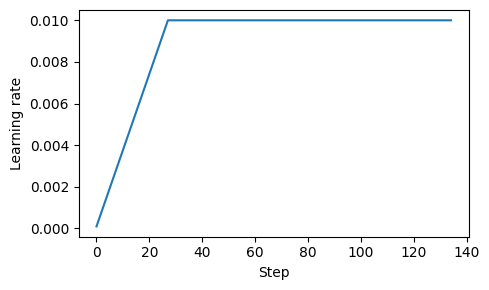

In [5]:
lr_increment=(peak_lr-initial_lr)/warmup_steps
global_step=-1
track_lrs=[]
optimizer=torch.optim.AdamW(model.parameters(),weight_decay=.1)
for epoch in range(n_epochs):
    for input_batch,target_batch in train_loader:
        optimizer.zero_grad()
        global_step+=1
        if global_step<warmup_steps:
            lr=initial_lr+global_step*lr_increment
        else:
            lr=peak_lr
        for param_group in optimizer.param_groups:
            param_group['lr']=lr
        track_lrs.append(optimizer.param_groups[0]['lr'])
plt.figure(figsize=(5,3))
plt.ylabel('Learning rate')
plt.xlabel('Step')
total_training_steps=len(train_loader)*n_epochs
plt.plot(range(total_training_steps),track_lrs)
plt.tight_layout()
plt.savefig('images/0.pdf')
plt.show()

# Cosine Decay

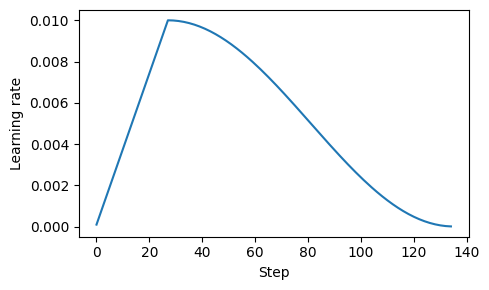

In [6]:
min_lr=.1*initial_lr
track_lrs=[]
lr_increment=(peak_lr-initial_lr)/warmup_steps
global_step=-1
for epoch in range(n_epochs):
    for input_batch,target_batch in train_loader:
        optimizer.zero_grad()
        global_step+=1
        if global_step<warmup_steps:
            lr=initial_lr+global_step*lr_increment  
        else:
            progress=((global_step-warmup_steps)/(total_training_steps-warmup_steps))
            lr=min_lr+(peak_lr-min_lr)*.5*(1+math.cos(math.pi*progress))
        for param_group in optimizer.param_groups:
            param_group['lr']=lr
        track_lrs.append(optimizer.param_groups[0]['lr'])
plt.figure(figsize=(5,3))
plt.ylabel('Learning rate')
plt.xlabel('Step')
plt.plot(range(total_training_steps),track_lrs)
plt.tight_layout()
plt.savefig('images/1.pdf')
plt.show()

# Gradient Clipping

In [7]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch=input_batch.to(device),target_batch.to(device)
    logits=model(input_batch)
    loss=torch.nn.functional.cross_entropy(logits.flatten(0,1),
                                           target_batch.flatten())
    return loss
model.to(device)
loss=calc_loss_batch(input_batch,target_batch,model,device)
loss.backward()
def find_highest_gradient(model):
    max_grad=None
    for param in model.parameters():
        if param.grad is not None:
            grad_values=param.grad.data.flatten()
            max_grad_param=grad_values.max()
            if max_grad is None or max_grad_param>max_grad:
                max_grad=max_grad_param
    return max_grad
find_highest_gradient(model)

tensor(0.0575, device='mps:0')

In [8]:
torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
find_highest_gradient(model)

tensor(0.0241, device='mps:0')

# Modified Training Function

In [9]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss=0
    if len(data_loader)==0:
        return float('nan')
    elif num_batches is None:
        num_batches=len(data_loader)
    else:
        num_batches=min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/num_batches
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss
def text_to_token_ids(text,tokenizer):
    encoded=tokenizer.encode(text)
    encoded_tensor=torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor
def generate_text_simple(model,idx,max_new_tokens,context_size):
    for _ in range(max_new_tokens):
        idx_cond=idx[:,-context_size:]
        with torch.no_grad():
            logits=model(idx_cond)
        logits=logits[:,-1,:]
        idx_next=torch.argmax(logits,dim=-1,keepdim=True)
        idx=torch.cat((idx,idx_next),dim=1)
    return idx
def token_ids_to_text(token_ids,tokenizer):
    flat=token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())
def generate_and_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size=model.pos_emb.weight.shape[0]
    encoded=text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids=generate_text_simple(model=model,
                                       idx=encoded,
                                       max_new_tokens=50,
                                       context_size=context_size)
        decoded_text=token_ids_to_text(token_ids,tokenizer)
        print(decoded_text.replace('\n',' '))
    model.train()
def train_model(model,train_loader,val_loader,optimizer,device,n_epochs,eval_freq,eval_iter,start_context,tokenizer,warmup_steps,initial_lr=3e-05,min_lr=1e-6):
    train_losses,val_losses,track_tokens_seen,track_lrs=[],[],[],[]
    tokens_seen,global_step=0,-1
    peak_lr=optimizer.param_groups[0]['lr']
    total_training_steps=len(train_loader)*n_epochs
    lr_increment=(peak_lr-initial_lr)/warmup_steps
    for epoch in range(n_epochs):
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()
            global_step+=1
            if global_step<warmup_steps:
                lr=initial_lr+global_step*lr_increment  
            else:
                progress=((global_step-warmup_steps)/(total_training_steps-warmup_steps))
                lr=min_lr+(peak_lr-min_lr)*.5*(1+math.cos(math.pi*progress))
            for param_group in optimizer.param_groups:
                param_group['lr']=lr
            track_lrs.append(lr)
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()
            if global_step>=warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
            optimizer.step()
            tokens_seen+=input_batch.numel()
            if global_step%eval_freq==0:
                train_loss,val_loss=evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f'Ep {epoch+1} (Iter {global_step}) | Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f}')
        generate_and_print_sample(model,tokenizer,device,start_context)
    return train_losses,val_losses,track_tokens_seen,track_lrs
peak_lr=.001
optimizer=torch.optim.AdamW(model.parameters(),lr=peak_lr,weight_decay=.1)
tokenizer=tiktoken.get_encoding('gpt2')
train_losses,val_losses,tokens_seen,lrs=train_model(model,train_loader,val_loader,optimizer,device,n_epochs=n_epochs,eval_freq=5,eval_iter=1,start_context='Every effort moves you',tokenizer=tokenizer,warmup_steps=warmup_steps,initial_lr=1e-5,min_lr=1e-5)

Ep 1 (Iter 0) | Train loss: 10.834 | Val loss: 10.985
Ep 1 (Iter 5) | Train loss: 9.342 | Val loss: 9.406
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,, the,,,,,,,,
Ep 2 (Iter 10) | Train loss: 7.913 | Val loss: 8.248
Ep 2 (Iter 15) | Train loss: 6.323 | Val loss: 6.927
Every effort moves you the the the, the the the the, the the the the the the the the the the the the the the, the the the, the the the the the the, the, the the the, the, the the the, the the the
Ep 3 (Iter 20) | Train loss: 5.867 | Val loss: 6.546
Ep 3 (Iter 25) | Train loss: 5.575 | Val loss: 6.641
Every effort moves you of the to the". ". ", the to the of the to the". ", the to the to the to the to the", the to the the of the the to the to the--. "
Ep 4 (Iter 30) | Train loss: 5.581 | Val loss: 6.662
Ep 4 (Iter 35) | Train loss: 4.805 | Val loss: 6.516
Every effort moves you a                                                 
Ep 5 (Iter 40) | Train loss: 4.479 | Val loss: 6.496
Every effort moves y

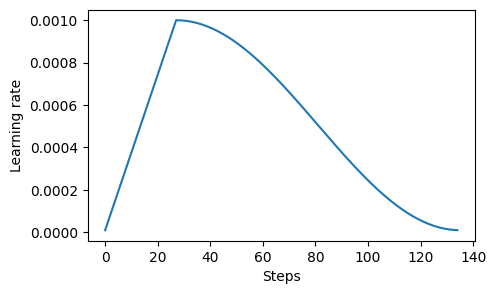

In [10]:
plt.figure(figsize=(5,3))
plt.plot(range(len(lrs)),lrs)
plt.ylabel('Learning rate')
plt.xlabel('Steps')
plt.show()

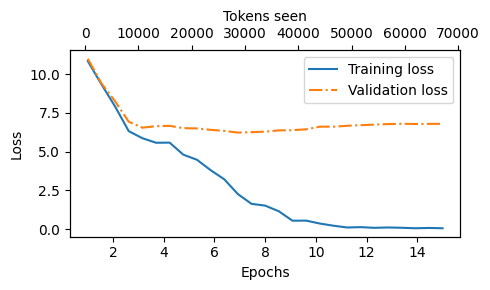

In [11]:
def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
    fig,ax1=plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_losses,label='Training loss')
    ax1.plot(epochs_seen,val_losses,linestyle='-.',label='Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax2=ax1.twiny()  
    ax2.plot(tokens_seen,train_losses,alpha=0)
    ax2.set_xlabel('Tokens seen')
    fig.tight_layout()
epochs_tensor=torch.linspace(1,n_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)
plt.tight_layout()
plt.savefig('images/2.pdf')
plt.show()